<b>Overview</b><br>
This is a rundown of the dictionary learning pipeline, using a small set of 8 microscopy images (from bbbc017), so that runtimes and memory requirements are manageable. The 8 images are from 4 separate treatments, each with 2 samples (images). Steps are:
1. <b>Extract patches</b> - we extract all possible patches, except for a few at the borders of the image. 
2. <b>Dictionary Learning</b> - fit the dictionary based on all 8 images.
3. <b>Sparse Coding</b> - Get a sparse coding of each image based on the fitted dictionary.
4. <b>2-Means Clustering</b> - Use 2-means clustering to cluster the images to see if the clusters they form coincide with their ground truth labels. 
4. <b>Visualization</b> - Lower-dimensional visualization of the sparse representations to see how well (or not) they separate. 

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import re
import sys
import pandas as pd
from __future__ import division

from skimage import io, filters, util, data, img_as_float
import microscopium as mic
import microscopium.features as micfeat
import scipy
import brewer2mpl

from sklearn.cluster import KMeans
from sklearn.decomposition import MiniBatchDictionaryLearning, SparseCoder, PCA
from sklearn.feature_extraction.image import extract_patches_2d, PatchExtractor, reconstruct_from_patches_2d
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal
from sklearn.manifold import TSNE

#os.getcwd()
os.chdir("/Users/don/Documents/hcs")
sys.path.append("/Users/don/Documents/PyModules")

#Tell numpy to skip division by zero in broadcasting
np.seterr(divide = 'ignore', invalid = 'ignore')

import skynet.pipeline

<font size = 5>1. Patch Extraction</font>

In [9]:
#Load the images
path = "/Users/don/Documents/hcs/images/"
imgs_fn = os.listdir(path)

#Prep a list of images in the directory given by 'path'
img_list = []

for line in imgs_fn:
    #Ignore hidden files, or at least files that start with '.'
    if not line.startswith('.') and os.path.isfile(os.path.join(path, line)):
        path_2 = path + line
        #print(path_2)
        img_list.append(img_as_float(io.imread(path_2)[:,:,:3]))


In [3]:
#Get patches
img_collection = np.array(img_list)
# >> img_collection.shape (8, 840, 842, 3)
# 8 images of shape (840, 843, 3)


In [4]:
#Takes about 11 min
t0 = time.time()
patch_size = (10,10)
print('Patches: Extracting patches...')
data = PatchExtractor(patch_size).transform(img_collection)
print("Data shape before reshape: %s" % (data.shape,))
print('Patches: Reshaping data...')
data = data.reshape(data.shape[0],-1)
print('Patches: Reshape complete')
print("Data shape before reshape: %s" % (data.shape,))
print('Patches: Broadcasting for normalization...')
data -= np.mean(data, axis = 0)
data /= np.std(data, axis = 0)
data[np.isnan(data)] = 0.0
print('done in %.2fs.' % (time.time() - t0))

#Final data.shape = (5537784, 300)
#ref. Denoising.ipynb to see notes about zero-div error in broadcasting, and NaN

Patches: Extracting patches...
Data shape before reshape: (5537784, 10, 10, 3)
Patches: Reshaping data...
Patches: Reshape complete
Data shape before reshape: (5537784, 300)
Patches: Broadcasting for normalization...
done in 703.47s.


In [5]:
#Save patch data
np.save("data",data)

<i>Technical note about DL</i>: MiniBatchDictionaryLearning implements a faster, but less accurate version of the dictionary learning algorithm that is better suited for large datasets.

By default, MiniBatchDictionaryLearning divides the data into mini-batches and optimizes in an online manner by cycling over the mini-batches for the specified number of iterations. However, at the moment it does not implement a stopping condition.

The estimator also implements partial_fit, which updates the dictionary by iterating only once over a mini-batch. This can be used for online learning when the data is not readily available from the start, or for when the data does not fit into the memory.

ref.http://scikit-learn.org/stable/modules/decomposition.html#dictionarylearning

<font size = 5>2. Dictionary Learning</font><br>Now let's learn a dictionary.

In [ ]:
# Try Juan's code
batch_size = 500

for iternum in range(data.shape[0] // batch_size):
    batch = data[iternum*batch_size : (iternum+1)*batch_size]
    dico.fit_partial(batch)

In [6]:
#Learning the dictionary
#Takes awhile: about 90 mins for 500 iterations. 
t0 = time.time()
dico = MiniBatchDictionaryLearning(n_components = 500, 
                                   alpha = 2, 
                                   n_iter = 500)
V = dico.fit(data).components_
dt = time.time() - t0
print('done in %.2fs, goddamn.' % dt)

#Normalize V to [0,1] first before plotting
#We shouldn't be needing V for any computational step...I think
W = (V - V.min())/(V.max() - V.min())

done in 6071.40s, goddamn.


In [5]:
#runtime: 6417.57s for 100 columns, alpha = 2, n_iter = 10
#Let's just override that last one; it was junk anyway

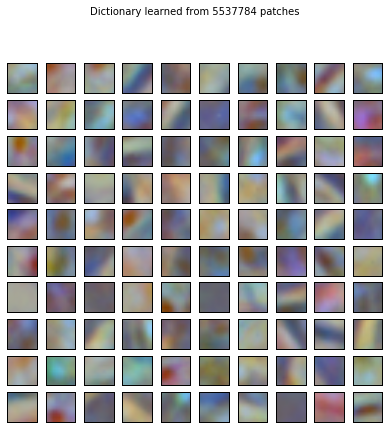

In [7]:
#imshow the learnt dictionary
plt.figure(figsize = (6.3, 6))
for i, comp in enumerate(W[:100]):
    plt.subplot(10,10, i+1)
    plt.imshow(comp.reshape(10,10,3))
    plt.xticks(())
    plt.yticks(())
    plt.suptitle('Dictionary learned from %d patches' % len(data))
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

In [8]:
#Save variables as .npy
np.save("W_500iter_2jul2016",W)
np.save("V_500iter_2jul2016",V)
#np.save("data",data)

<font size = 5>3. Sparse Coding</font>

In [4]:
#Get image dimensions
width, height, ch = img_collection[0].shape

In [5]:
#Patch and normalize images
#Initialize list of input signals, Y
#Takes about a minute per image

Y = [] #This will be a list of patches
t0 = time.time()

for img in img_list:
    img_f = img_as_float(img)
    y = skynet.pipeline.patch_and_Gnormalize(img_f, (10,10), verbose=False)
    Y.append(y)

print("")
print('All done in %.2fs.' % (time.time() - t0))

#Y[0].shape (692223, 300)


All done in 96.68s.


In [11]:
# Sparse encoding step

# s.t. we have Y1 = D*X1, 
# D is the learnt dictionary
# Y1 is the image
# X1 is the sparse encoding of the input signal

X = []
t0 = time.time()

#Preallocate X instead of appending?
# Each signal takes about 75s
print('Sparse encoding: %s signals to encode' % len(Y))
print('')
for i in range(len(Y)):
    t_i = time.time()
    print('Encoding signal %s...' % i)
    coder = SparseCoder(dictionary = W, 
                        transform_algorithm = 'omp')
    x = coder.transform(Y[i])
    X.append(x)
    print('Encoding completed in %.2fs' % (time.time() - t_i))
    print('')
    
print('All done in %.2fs.' % (time.time() - t0))

#X.shape (8, 692223, 100)
# 8 images, each shape (692223, 100)

Sparse encoding: 8 signals to encode

Encoding signal 0...
y.shape = (692223, 300) 
Dictionary shape = (100, 300)
x.shape = (692223, 100)
Encoding completed in 76.28s

Encoding signal 1...
y.shape = (692223, 300) 
Dictionary shape = (100, 300)
x.shape = (692223, 100)
Encoding completed in 70.55s

Encoding signal 2...
y.shape = (692223, 300) 
Dictionary shape = (100, 300)
x.shape = (692223, 100)
Encoding completed in 72.14s

Encoding signal 3...
y.shape = (692223, 300) 
Dictionary shape = (100, 300)
x.shape = (692223, 100)
Encoding completed in 73.76s

Encoding signal 4...
y.shape = (692223, 300) 
Dictionary shape = (100, 300)
x.shape = (692223, 100)
Encoding completed in 70.98s

Encoding signal 5...
y.shape = (692223, 300) 
Dictionary shape = (100, 300)
x.shape = (692223, 100)
Encoding completed in 73.08s

Encoding signal 6...
y.shape = (692223, 300) 
Dictionary shape = (100, 300)
x.shape = (692223, 100)
Encoding completed in 82.28s

Encoding signal 7...
y.shape = (692223, 300) 
Dictio

//anaconda/lib/python3.5/site-packages/sklearn/decomposition/dict_learning.py:152: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T


In [27]:
#Save the matrix of sparse codings X
np.save("X_2july2016",X)

In [2]:
# Don't load these in a full-run pipeline!
X = np.load("X_2july2016.npy")
W = np.load("W_500iter_2jul2016.npy")
V = np.load("V_500iter_2jul2016.npy")

<font size= 5>Intermission: Reconstruction Based on Sparse Encodings</font><br>Let's see how well the images are reconstructed based on only their sparse representations. Put this in a pipeline to plot an image of choice.

Dot product patches.shape = (692223, 300)
Reshaped patches.shape = (692223, 10, 10, 3)
Reconstructed x.shape = (840, 842, 3)


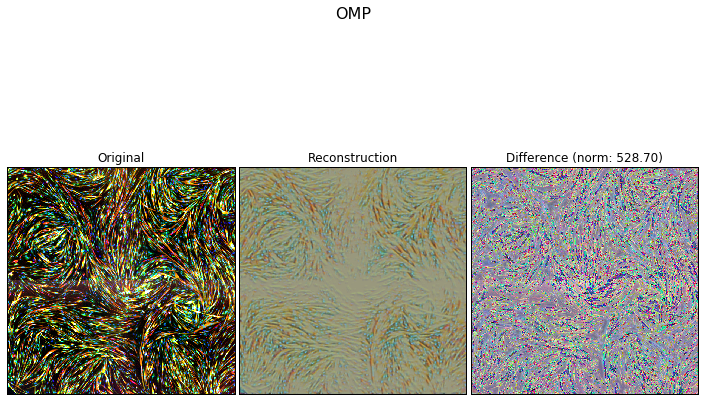

In [7]:
idx = 2

#Reconstruction of just X[1]
patches = np.dot(X[idx],W)
print("Dot product patches.shape = %s" % (patches.shape,))
#Should be (692223, 300)

#Fatten the 2D matrix into a 4D block...(why 4d?)
patches = patches.reshape(len(X[idx]), 10,10,3)
print("Reshaped patches.shape = %s" % (patches.shape,))
#Should be (692223, 10, 10, 3)

x = reconstruct_from_patches_2d(patches, (width, height, 3))
print("Reconstructed x.shape = %s" % (x.shape,))
#Should be 840, 842, 3

x_Normed = (x - x.min())/(x.max() - x.min())

skynet.pipeline.show_with_diff(img_list[idx], x_Normed, 'OMP')

<font size = 5>2-means Clustering</font><br>
Original labelling details at https://github.com/microscopium/microscopium/blob/master/tests/testdata/wells_test.json

In [3]:
X=np.array(X)
n, h, w = X.shape
print(X.shape)

(8, 692223, 100)

In [5]:
x_vec = np.zeros((n,w))
for i in range(n):
    x_row = skynet.pipeline.flatten_sparse_matrix(X[i])
    #print(x_row.shape)
    x_vec[i] = x_row

#x_vec.shape (8, 100)
print(x_vec.shape)

(8, 100)

In [6]:
# Visualize the results on PCA-reduced data
# First, check the explained variance ratio of the first few PCs
n_PCs = 4# No. of PCs
x_vec_redux = PCA(n_components = n_PCs)
x_vec_redux_fit = x_vec_redux.fit_transform(x_vec)
#type(x_vec_redux) sklearn.decomposition.pca.PCA
#This object type has the explained_variance_ratio attribute, 
#but KMeans requires an np array
#There may be a more elegant solution; cast objects separately for now

POV = x_vec_redux.explained_variance_ratio_
for i in range(n_PCs):
    print(POV[i])

0.893175986657
0.0705245233168
0.0272315337171
0.00575090227778


In [93]:
x_vec_redux = PCA(n_components = n_PCs).fit_transform(x_vec)

kmeans = KMeans(n_clusters=4, n_init=10) #estimator object
Z = kmeans.fit_transform(x_vec_redux)

km_labels = kmeans.labels_
#type(km_labels) np.array
print(km_labels)

[1 3 2 0 2 1 0 3]


In [29]:
def get_plate_well(fn):
    """Extracts the plate number from the given file name
    """
    pattern = re.compile(r'_[\d]*')
    pnum = re.findall(pattern, fn)
    if len(pnum) > 1:
        print("Warning: %s matches for plate number found" % len(pnum))
        print("Default behaviour: use first match")
    platenum = pnum[0].strip('_')
    
    pattern2 = re.compile(r'_[A-z][0-9][0-9]_')
    wn = re.findall(pattern2, fn)
    if len(wn) > 1:
        print("Warning: %s matches for plate number found" % len(wn))
        print("Default behaviour: use first match")
    wellnum = wn[0].strip('_')
    
    platewell = platenum + '-' + wellnum

    return platewell

In [94]:
plate_well_list = []
for i in range(1,9):
    plate_well_list.append(get_plate_well(imgs_fn[i]))

Default behaviour: use first match
Default behaviour: use first match
Default behaviour: use first match
Default behaviour: use first match
Default behaviour: use first match
Default behaviour: use first match
Default behaviour: use first match
Default behaviour: use first match


In [95]:
plate_well_list

['02490700-H05',
 '02490700-L13',
 '02490701-G03',
 '02490701-L04',
 '02490702-G03',
 '02490702-H05',
 '02490702-L04',
 '02490702-L13']

The result [0 0 0 1 0 0 1 0] is a partial success - the it distinguishes L04 from all other wells, which corresponds to the gene nudt3.

In [96]:
bmap = brewer2mpl.get_map("Paired", "Qualitative", 12)
color_scale = dict(zip(km_labels, bmap.mpl_colors))

In [97]:
# Try plotting based on PCA
# First put everything in a pd.Dataframe

x_vec_redux_fit.shape
x_vec_x = x_vec_redux_fit[:,0]
x_vec_y = x_vec_redux_fit[:,1]

dframe0 = pd.DataFrame(dict(x=x_vec_x, 
                            y=x_vec_y,
                           label=km_labels))

df0_named = pd.DataFrame(dict(x=x_vec_x, 
                            y=x_vec_y,
                           label=plate_well_list))

groups = dframe0.groupby('label')

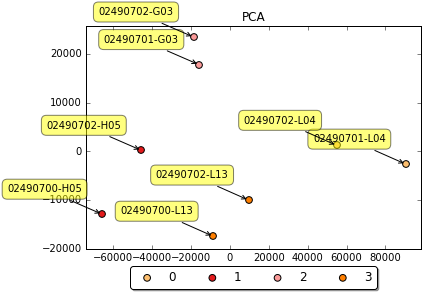

In [101]:
fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in groups:
    ax.scatter(group.x, group.y, s=45, label=name, c=color_scale[name])
    
ax.legend(scatterpoints=1, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)

for label, x, y in zip(plate_well_list, dframe0['x'], dframe0['y']):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.title("PCA")

In [35]:
# Try tSNE

In [36]:
from sklearn.manifold import TSNE

In [123]:
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
x_tsne = model.fit_transform(x_vec)

In [124]:
x_vec_x = x_tsne[:,0]
x_vec_y = x_tsne[:,1]

df_tsne = pd.DataFrame(dict(x=x_vec_x, 
                            y=x_vec_y,
                           label=plate_well_list))
df_tsne

,label,x,y
0,02490700-H05,0.000176,0.000040
1,02490700-L13,0.000098,0.000222
2,02490701-G03,0.000186,-0.000096
3,02490701-L04,0.000095,-0.000015
4,02490702-G03,-0.000009,0.000041
5,02490702-H05,0.000015,0.000145
6,02490702-L04,0.000076,0.000013
7,02490702-L13,0.000045,0.000034


AttributeError: Unknown property xlim

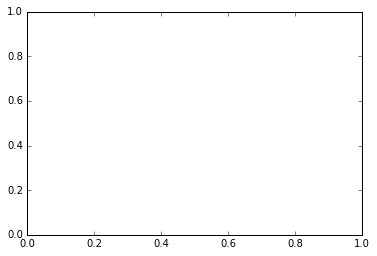

In [134]:
plt.scatter(df_tsne['x'],df_tsne['y'],xlim=[-0.005, 0.005])
